BioPandas

Author: Sebastian Raschka <mail@sebastianraschka.com>  
License: BSD 3 clause  
Project Website: http://rasbt.github.io/biopandas/  
Code Repository: https://github.com/rasbt/biopandas  

In [1]:
%load_ext watermark
%watermark -d -u -p pandas,biopandas

last updated: 2017-09-27 

pandas 0.20.3
biopandas 0.2.3dev0


In [2]:
from biopandas.mol2 import PandasMol2
import pandas as pd
pd.set_option('display.width', 600)
pd.set_option('display.max_columns', 8)

# Working with MOL2 Structures in DataFrames

The Tripos MOL2 format is a common format for working with small molecules. In this tutorial, we will go over some examples that illustrate how we can use Biopandas' MOL2 DataFrames to analyze molecules conveniently.

## Loading MOL2 Files

Using the `read_mol2` method, we can read MOL2 files from standard .mol2 text files:

In [3]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2().read_mol2('./data/1b5e_1.mol2')

[File link: [1b5e_1.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/1b5e_1.mol2)]

The `read_mol2` method can also load structures from `.mol2.gz` files, but if you have a multi-mol2 file, keep in mind that it will only fetch the first molecule in this file. In the section "[Parsing Multi-MOL2 files](#parsing-multi-mol2-files)," we will see how we can parse files that contain multiple structures.

In [4]:
pmol = PandasMol2().read_mol2('./data/40_mol2_files.mol2.gz')

[File link: [40_mol2_files.mol2.gz](https://github.com/rasbt/biopandas/blob/master/docs/sources/tutorials/data/40_mol2_files.mol2.gz?raw=true)]

After the file was succesfully loaded, we have access to the following basic `PandasMol2` attributes:

In [5]:
print('Molecule ID: %s' % pmol.code)
print('\nRaw MOL2 file contents:\n\n%s\n...' % pmol.mol2_text[:500])

Molecule ID: ZINC38611810

Raw MOL2 file contents:

@<TRIPOS>MOLECULE
ZINC38611810
   65    68     0     0     0
SMALL
NO_CHARGES

@<TRIPOS>ATOM
      1 C1         -1.1786    2.7011   -4.0323 C.3       1 <0>        -0.1537
      2 C2         -1.2950    1.2442   -3.5798 C.3       1 <0>        -0.1156
      3 C3         -0.1742    0.4209   -4.2178 C.3       1 <0>        -0.1141
      4 C4         -0.2887   -1.0141   -3.7721 C.2       1 <0>         0.4504
      5 O1         -1.1758   -1.3445   -3.0212 O.2       1 <0>        -0.4896
      6 O2       
...


The most interesting and useful attribute, however, is the [`PandasMol2.df`](../api/biopandas.mol2#pandasmol2df) DataFrame, which contains the ATOM section of the MOL2 structure. Let's print the first 3 lines from the `ATOM` coordinate section to see how it looks like:

In [6]:
pmol.df.head(3)

,atom_id,atom_name,x,y,...,atom_type,subst_id,subst_name,charge
0,1,C1,-1.1786,2.7011,...,C.3,1,<0>,-0.1537
1,2,C2,-1.2950,1.2442,...,C.3,1,<0>,-0.1156
2,3,C3,-0.1742,0.4209,...,C.3,1,<0>,-0.1141


## The MOL2 Data Format

`PandasMol2` expects the MOL2 file to be in the standard Tripos MOL2 format, and most importantly, that the "@<TRIPOS>ATOM" section is consistent with the following format convention:


> Format:
     **atom_id atom_name x y z atom_type [subst_id
        [subst_name [charge [status_bit]]]]**
       
> - atom_id (integer) = the ID number of the atom at the time the file was created. This is provided for reference only and is not used when the .mol2 file is read into SYBYL.
- atom_name (string) = the name of the atom.
- x (real) = the x coordinate of the atom.
- y (real) = the y coordinate of the atom.
- z (real) = the z coordinate of the atom.
- atom_type (string) = the SYBYL atom type for the atom.
- subst_id (integer) = the ID number of the substructure containing the atom.
- subst_name (string) = the name of the substructure containing the atom.
- charge (real) = the charge associated with the atom.
- status_bit (string) = the internal SYBYL status bits associated with the atom. These should never be set by the user. Valid status bits are DSPMOD, TYPECOL, CAP, BACKBONE, DICT, ESSENTIAL, WATER and DIRECT.

For example, the contents of a typical Tripos MOL2 file may look like this:

```
@<TRIPOS>MOLECULE
DCM Pose 1
   32    33     0     0     0
SMALL
USER_CHARGES
@<TRIPOS>ATOM
      1 C1         18.8934    5.5819   24.1747 C.2       1 <0>       -0.1356 
      2 C2         18.1301    4.7642   24.8969 C.2       1 <0>       -0.0410 
      3 C3         18.2645    6.8544   23.7342 C.2       1 <0>        0.4856 
...
     31 H11        18.5977    8.5756   22.6932 H         1 <0>        0.4000 
     32 H12        14.2530    1.0535   27.4278 H         1 <0>        0.4000 
@<TRIPOS>BOND
    1     1     2 2
    2     1     3 1
    3     2    11 1
    4     3    10 2
    5     3    12 1
...
   28     8    27 1
   29     9    28 1
   30     9    29 1
   31    12    30 1
   32    12    31 1
   33    18    32 1
```

## Working with MOL2 DataFrames

In the previous sections, we've seen how to load MOL2 structures into DataFrames and how to access them. Once, we have the ATOM section of a MOL2 file in a DataFrame format, we can readily slice and dice the molecular structure and analyze it.
To demonstrate some typical use cases, let us load the structure of deoxycytidylate hydroxymethylase (DCM), which is shown in the figure below:

![](./img/1b5e_1.png)

In [7]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2()
pmol.read_mol2('./data/1b5e_1.mol2')
pmol.df.tail(10)

,atom_id,atom_name,x,y,...,atom_type,subst_id,subst_name,charge
22,23,H3,15.8520,2.8983,...,H,1,<0>,0.0
23,24,H4,14.3405,3.3601,...,H,1,<0>,0.0
24,25,H5,15.3663,0.9351,...,H,1,<0>,0.0
25,26,H6,16.6681,1.6130,...,H,1,<0>,0.0
26,27,H7,15.3483,4.6961,...,H,1,<0>,0.0
27,28,H8,18.8490,1.8078,...,H,1,<0>,0.0
28,29,H9,17.8303,1.5497,...,H,1,<0>,0.0
29,30,H10,19.9527,7.4708,...,H,1,<0>,0.4
30,31,H11,18.5977,8.5756,...,H,1,<0>,0.4
31,32,H12,14.2530,1.0535,...,H,1,<0>,0.4


[File link: [1b5e_1.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/1b5e_1.mol2)]

For example, we can select all hydrogen atoms by filtering on the atom type column:

In [8]:
pmol.df[pmol.df['atom_type'] != 'H'].tail(10)

,atom_id,atom_name,x,y,...,atom_type,subst_id,subst_name,charge
10,11,N2,16.8196,5.0644,...,N.am,1,<0>,-0.4691
11,12,N3,19.0194,7.7275,...,N.pl3,1,<0>,-0.8500
12,13,O1,18.7676,-2.3524,...,O.3,1,<0>,-1.0333
13,14,O2,20.3972,-0.3812,...,O.3,1,<0>,-1.0333
14,15,O3,15.0888,6.5824,...,O.2,1,<0>,-0.5700
15,16,O4,18.9314,-0.7527,...,O.2,1,<0>,-1.0333
16,17,O5,16.9690,3.4315,...,O.3,1,<0>,-0.5600
17,18,O6,14.3223,1.8946,...,O.3,1,<0>,-0.6800
18,19,O7,17.9091,-0.0135,...,O.3,1,<0>,-0.5512
19,20,P1,19.0969,-0.9440,...,P.3,1,<0>,1.3712


Or, if we like  to count the number of keto-groups in this molecule, we can do the following:

In [9]:
keto = pmol.df[pmol.df['atom_type'] == 'O.2']
print('number of keto groups: %d' % keto.shape[0])
keto

number of keto groups: 2


,atom_id,atom_name,x,y,...,atom_type,subst_id,subst_name,charge
14,15,O3,15.0888,6.5824,...,O.2,1,<0>,-0.5700
15,16,O4,18.9314,-0.7527,...,O.2,1,<0>,-1.0333


A list of all the allowed atom types that can be found in Tripos MOL2 files is provided below:

    Code       Definition
    C.3        carbon sp3
    C.2        carbon sp2
    C.1        carbon sp
    C.ar       carbon aromatic
    C.cat      cabocation (C+) used only in a guadinium group
    N.3        nitrogen sp3
    N.2        nitrogen sp2
    N.1        nitrogen sp
    N.ar       nitrogen aromatic
    N.am       nitrogen amide
    N.pl3      nitrogen trigonal planar
    N.4        nitrogen sp3 positively charged
    O.3        oxygen sp3
    O.2        oxygen sp2
    O.co2      oxygen in carboxylate and phosphate groups
    O.spc      oxygen in Single Point Charge (SPC) water model
    O.t3p      oxygen in Transferable Intermolecular Potential (TIP3P) water model
    S.3        sulfur sp3
    S.2        sulfur sp2
    S.O        sulfoxide sulfur
    S.O2/S.o2  sulfone sulfur
    P.3        phosphorous sp3
    F          fluorine
    H          hydrogen
    H.spc      hydrogen in Single Point Charge (SPC) water model
    H.t3p      hydrogen in Transferable Intermolecular Potential (TIP3P) water model
    LP         lone pair
    Du         dummy atom
    Du.C       dummy carbon
    Any        any atom
    Hal        halogen
    Het        heteroatom = N, O, S, P
    Hev        heavy atom (non hydrogen)
    Li         lithium
    Na         sodium
    Mg         magnesium
    Al         aluminum
    Si         silicon
    K          potassium
    Ca         calcium
    Cr.thm     chromium (tetrahedral)
    Cr.oh      chromium (octahedral)
    Mn         manganese
    Fe         iron
    Co.oh      cobalt (octahedral)
    Cu         copper


## Plotting

Since we are using pandas under the hood, which in turns uses matplotlib under the hood, we can produce quick summary plots of our MOL2 structures conveniently. Below are a few examples of how to visualize molecular properties.

In [10]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2().read_mol2('./data/1b5e_1.mol2')

[File link: [1b5e_1.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/1b5e_1.mol2)]

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

For instance, let's say we are interested in the counts of the different atom types that can be found in the MOL2 file; we could do the following:

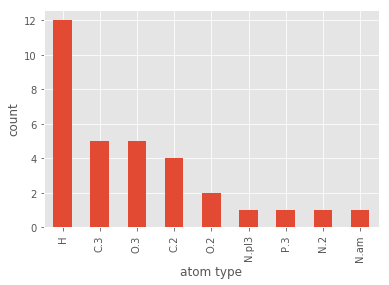

In [12]:
pmol.df['atom_type'].value_counts().plot(kind='bar')
plt.xlabel('atom type')
plt.ylabel('count')
plt.show()

If this is too fine-grained for our needs, we could summarize the different atom types by atomic elements:

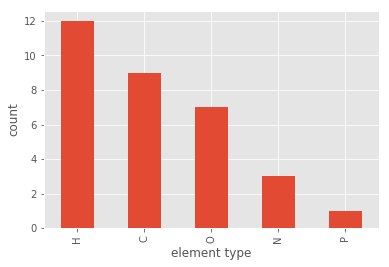

In [13]:
pmol.df['element_type'] = pmol.df['atom_type'].apply(lambda x: x.split('.')[0])

pmol.df['element_type'].value_counts().plot(kind='bar')
plt.xlabel('element type')
plt.ylabel('count')
plt.show()

One of the coolest features in pandas is the groupby method. Below is an example plotting the average charge of the different atom types with the standard deviation as error bars:

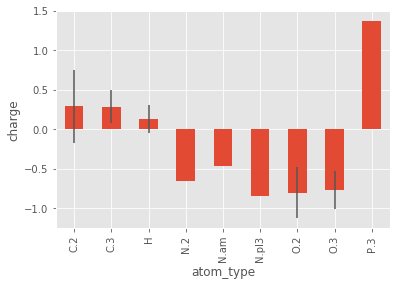

In [14]:
groupby_charge = pmol.df.groupby(['atom_type'])['charge']
groupby_charge.mean().plot(kind='bar', yerr=groupby_charge.std())
plt.ylabel('charge')
plt.show()

## Computing the Root Mean Square Deviation

The Root-mean-square deviation (RMSD) is simply a measure of the average distance between atoms of 2 structures. This calculation of the Cartesian error follows the equation:

$$RMSD(a, b) = \sqrt{\frac{1}{n} \sum^{n}_{i=1} \big((a_{ix})^2 + (a_{iy})^2 + (a_{iz})^2 \big)} \\
= \sqrt{\frac{1}{n} \sum^{n}_{i=1} || a_i + b_i||_2^2}$$

So, assuming that the we have the following 2 conformations of a ligand molecule

![](./img/1b5e_poses.png)

we can compute the RMSD as follows:

In [15]:
from biopandas.mol2 import PandasMol2

l_1 = PandasMol2().read_mol2('./data/1b5e_1.mol2')
l_2 = PandasMol2().read_mol2('./data/1b5e_2.mol2')

r_heavy = PandasMol2.rmsd(l_1.df, l_2.df)
r_all  = PandasMol2.rmsd(l_1.df, l_2.df, heavy_only=False)

print('Heavy-atom RMSD: %.4f Angstrom' % r_heavy)
print('All-atom RMSD: %.4f Angstrom' % r_all)

Heavy-atom RMSD: 1.1609 Angstrom
All-atom RMSD: 1.5523 Angstrom


[File links: [1b5e_1.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/1b5e_1.mol2), [1b5e_2.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/1b5e_2.mol2)]

<br>

## Filtering Atoms by Distance

We can use the `distance` method to compute the distance between each atom (or a subset of atoms) in our data frame and a three-dimensional reference point. For example, let's assume were are interested in computing the distance between a keto group in the DMC molecule, which we've seen earlier, and other atoms in the same molecule.

First, let's get the coordinates of all keto-groups in this molecule:

In [16]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2().read_mol2('./data/1b5e_1.mol2')

keto_coord = pmol.df[pmol.df['atom_type'] == 'O.2'][['x', 'y', 'z']]
keto_coord

,x,y,z
14,15.0888,6.5824,25.0727
15,18.9314,-0.7527,24.1606


In the following example, we use `PandasMol2`'s `distance` method. The `distance` method returns a pandas `Series` object containing the Euclidean distance between an atom and all other atoms in the structure. In the following example, `keto_coord.values[0]` refers to the x, y, z coordinates of the first row (i.e., first keto group) in the array above:

In [17]:
print('x, y, z coords:', keto_coord.values[0])
distances = pmol.distance(keto_coord.values[0])

x, y, z coords: [ 15.0888   6.5824  25.0727]


For our convenience, we can add these `distances` to our MOL2 DataFrame:

In [18]:
pmol.df['distances'] = distances
pmol.df.head()

,atom_id,atom_name,x,y,...,subst_id,subst_name,charge,distances
0,1,C1,18.8934,5.5819,...,1,<0>,-0.1356,4.035144
1,2,C2,18.1301,4.7642,...,1,<0>,-0.0410,3.547712
2,3,C3,18.2645,6.8544,...,1,<0>,0.4856,3.456969
3,4,C4,16.2520,6.2866,...,1,<0>,0.8410,1.232313
4,5,C5,15.3820,3.0682,...,1,<0>,0.0000,3.527546


Now, say we are interested in the Euclidean distance between the two keto groups in the molecule:

In [19]:
pmol.df[pmol.df['atom_type'] == 'O.2']

,atom_id,atom_name,x,y,...,subst_id,subst_name,charge,distances
14,15,O3,15.0888,6.5824,...,1,<0>,-0.5700,0.000000
15,16,O4,18.9314,-0.7527,...,1,<0>,-1.0333,8.330738


In the example above, the distance between the two keto groups is 8 angstrom.

![](./img/1b5e_ketodist.png)

Another common task that we can perform using these atomic distances is to select only the neighboring atoms of the keto group (here: atoms within 3 angstrom). The code is as follows:

In [20]:
all_within_3A = pmol.df[pmol.df['distances'] <= 3.0]
all_within_3A.tail()

,atom_id,atom_name,x,y,...,subst_id,subst_name,charge,distances
7,8,C8,16.0764,4.1199,...,1,<0>,0.5801,2.814490
9,10,N1,17.0289,7.1510,...,1,<0>,-0.6610,2.269690
10,11,N2,16.8196,5.0644,...,1,<0>,-0.4691,2.307553
14,15,O3,15.0888,6.5824,...,1,<0>,-0.5700,0.000000
26,27,H7,15.3483,4.6961,...,1,<0>,0.0000,2.446817


## Parsing Multi-MOL2 files

### Basic Multi-MOL2 File Parsing

As mentioned earlier, `PandasMol2.read_mol2` method only reads in the first molecule if it is given a multi-MOL2 file. However, if we want to create DataFrames from multiple structures in a MOL2 file, we can use the handy `split_multimol2` generator.

The `split_multimol2` generator yields tuples containing the molecule IDs and the MOL2 content as strings in a list -- each line in the MOL2 file is stored as a string in the list.

In [21]:
from biopandas.mol2 import split_multimol2

mol2_id, mol2_cont = next(split_multimol2('./data/40_mol2_files.mol2'))

print('Molecule ID:\n', mol2_id)
print('First 10 lines:\n', mol2_cont[:10])

Molecule ID:
 ZINC38611810
First 10 lines:
 ['@<TRIPOS>MOLECULE\n', 'ZINC38611810\n', '   65    68     0     0     0\n', 'SMALL\n', 'NO_CHARGES\n', '\n', '@<TRIPOS>ATOM\n', '      1 C1         -1.1786    2.7011   -4.0323 C.3       1 <0>        -0.1537\n', '      2 C2         -1.2950    1.2442   -3.5798 C.3       1 <0>        -0.1156\n', '      3 C3         -0.1742    0.4209   -4.2178 C.3       1 <0>        -0.1141\n']


[File link: [40_mol2_files.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/40_mol2_files.mol2)]

We can now use this generator to loop over all files in a multi-MOL2 file and create PandasMol2 DataFrames. A typical use case would be the filtering of mol2 files by certain properties:

In [22]:
pdmol = PandasMol2()

with open('./data/filtered.mol2', 'w') as f:
    for mol2 in split_multimol2('./data/40_mol2_files.mol2'):
        pdmol.read_mol2_from_list(mol2_lines=mol2[1], mol2_code=mol2[0])
        
        # do some analysis
        keep_molecule = False
        
        # save molecule if it passes our filter criterion
        if keep_molecule: 
            # note that the mol2_text contains the original mol2 content
            f.write(pdmol.mol2_text) 

### Using Multiprocessing for Multi-MOL2 File Analysis

To improve the computational efficiency and throughput for multi-mol2 analyses, it is recommended to use the [`mputil`](https://github.com/rasbt/mputil) package, which evaluates Python generators lazily. The `lazy_imap` function from `mputil` is based on Python's standardlib multiprocessing `imap` function, but it doesn't consume the generator upfront. This lazy evaluation is important, for example, if we are parsing large (possibly Gigabyte- or Terabyte-large) multi-mol2 files for multiprocessing.

The following example provides a template for atom-type based molecule queries, but the `data_processor` function can be extended to do any kind of functional group queries (for example, involving the `'charge'` column and/or `PandasMol2.distance` method). 

In [23]:
import pandas as pd
from mputil import lazy_imap
from biopandas.mol2 import PandasMol2
from biopandas.mol2 import split_multimol2

In [24]:
# Selection strings to capture
# all molecules that contain at least one sp2 hybridized
# oxygen atom and at least one Fluorine atom
SELECTIONS = ["(pdmol.df.atom_type == 'O.2')",
              "(pdmol.df.atom_type == 'F')"]
 
# Path to the multi-mol2 input file
MOL2_FILE = "./data/40_mol2_files.mol2"

# Data processing function to be run in parallel
def data_processor(mol2):
    """Return molecule ID if there's a match and '' otherwise"""
    pdmol = PandasMol2().read_mol2_from_list(mol2_lines=mol2[1],
                                             mol2_code=mol2[0])
    match = mol2[0]
    for sub_sele in SELECTIONS:
        if not pd.eval(sub_sele).any():
            match = ''
            break
    return match

# Process molecules and save IDs of hits to disk
with open('./data/selected_ids.txt', 'w') as f:       
    searched, found = 0, 0
    for chunk in lazy_imap(data_processor=data_processor,
                           data_generator=split_multimol2(MOL2_FILE),
                           n_cpus=0): # means all available cpus

        for mol2_id in chunk:
            if mol2_id:
                # write IDs of matching molecules to disk
                f.write('%s\n' % mol2_id)
                found += 1
        searched += len(chunk)
            
        
print('Searched %d molecules. Got %d hits.' % (searched, found))

Searched 40 molecules. Got 3 hits.


[Input File link: [40_mol2_files.mol2](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/40_mol2_files.mol2)]

[Output File link: [selected_ids.txt](https://raw.githubusercontent.com/rasbt/biopandas/master/docs/sources/tutorials/data/selected_ids.txt)]